## IBM Data Science Capstone final Project
## “Finding best neighborhoods in Downtown San Diego to open a French Restaurant”


## Introduction

 Our client **XYZ French food chain** is interested in opening a **new French Restaurant** in **Downtown San Diego neighborhood**. For that they have asked us to do research of Downtown San Diego area and suggest probable locations for opening a new French restaurant.
                        Downtown San Diego is the city center of San Diego, California, the eighth largest city in the United States. Downtown San Diego serves as the cultural and financial center and central business district of San Diego, with more than 4,000 businesses and following  neighborhoods

**Columbia** - the west district of downtown. Located between the Marina and Little Italy, west of Columbia Street   
**Civic Core** - District, the central business district of downtown    
**Cortez Hill** - the northeast district of downtown    
**East Village** - the east district of downtown, which is home to Petco Park and the surrounding Ballpark Village   
**Gaslamp** - Quarter, a two- by ten-block nightlife district in central Downtown   
**Little Italy** -  the northwest district of downtown  
**Marina** - the southwest district of downtown, which is home to Seaport Village and Pantoja Park  
            Downtown San Diego encompasses seven thriving neighborhoods, each with its own unique identity.    
In this project, will use the Foursquare APIs to extract the venues of Downtown San Diego neighborhoods to analyze the different neighborhoods, overall Restaurant business, in specific French Restaurant locations and probable neighborhoods where a new French restaurant can be started as specified by our client. Will use the Data Analysis and Machine Learning techniques for accomplishing the given task.       
Target Audience - Our client **XYZ French food chain**, who is interested in opening a new French Restaurant in Downtown San Diego neighborhood

Before we start lets import all the dependent libraries

In [40]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data Download and preprocessing

Downtown San Diego has following seven neighborhoods i.e. **Civic Core, Columbia, Cortez Hill, Gaslamp, Little Italy, Marina and East Village**   
which are extracted from following links   
https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego   
https://www.luxurylivingsd.com/guide/san-diego/

Now to extract the Latitude and Longitude coordinates of these neighborhoods, will take help of following links where this info is present  
http://sqldbpros.com/2011/11/free-zip-code-city-county-state-csv/  
http://download.geonames.org/export/dump/  
https://www.latlong.net/convert-address-to-lat-long.html 

After extracting both the neighborhood names and its location coordinates, they are saved in in csv format

In [2]:
#Read the preprocessed csv file which has Downtown San Diego neighborhood names and its location info
df = pd.read_csv('SD1_LatLong_Dataset.csv')
df

,Borough,Neighborhood,Latitude,Longitude,City
0,Downtown SanDiego,CIVIC_CORE,32.7159,-117.1595,San Diego
1,Downtown SanDiego,COLUMBIA,32.7178,-117.1673,San Diego
2,Downtown SanDiego,CORTEZ HILL,32.7214,-117.1598,San Diego
3,Downtown SanDiego,GASLAMP,32.7101,-117.1601,San Diego
4,Downtown SanDiego,LITTLE ITALY,32.7234,-117.1682,San Diego
5,Downtown SanDiego,MARINA,32.7108,-117.1701,San Diego
6,Downtown SanDiego,EAST VILLAGE,32.7137,-117.1536,San Diego


In [3]:
df.shape

(7, 5)

In [3]:
print('The dataframe has {} Borough and {} Neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 1 Borough and 7 Neighborhoods.


In [4]:
#count Bourough and Neighborhood
df.groupby('Borough').count()['Neighborhood']

Borough
Downtown SanDiego    7
Name: Neighborhood, dtype: int64

In [5]:
#Create list with the Boroughs (to be used later)
boroughs = df['Borough'].unique().tolist()
boroughs

['Downtown SanDiego']

In [9]:
#Use geopy library to get the latitude and longitude values of Downtown San Diego
address = 'San Diego, CA'

geolocator = Nominatim(user_agent="sd_explorer")
location = geolocator.geocode(address)
lat_sd = location.latitude
lon_sd = location.longitude
print('The Geograpical coordinates of Downtown San Diego are {}, {} '.format(lat_sd, lon_sd))

The Geograpical coordinates of Downtown San Diego are 32.7174209, -117.1627714 


In [10]:
#Another way to obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_sd = df['Latitude'].mean()
lon_sd = df['Longitude'].mean()
print('The Geographical coordinates of Downtown San Diego are {}, {}'.format(lat_sd, lon_sd))

The Geographical coordinates of Downtown San Diego are 32.71615714285714, -117.16265714285714


In [11]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [12]:
#Create a map of Downtown San Diego with neighborhoods superimposed on top
map_sd = folium.Map(location=[lat_sd, lon_sd], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], 
                                           df['Longitude'],
                                           df['Borough'], 
                                           df['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7).add_to(map_sd)  
    
map_sd

## Getting Venues Data using Foursquare

In [13]:
#CLIENT_ID = '' # your Foursquare ID
#CLIENT_SECRET = '' # your Foursquare Secret

CLIENT_ID = 'M5BXE2CLGK4EP4T0N1F3NR1ORUIQG02OC3YKFVZ2IYX0YFCC' # my Foursquare ID
CLIENT_SECRET = 'AIV4OC1KRX41ZN2KKACRTBISHQB3UBV3CPMVF5BQK4SFO31Q' # your Foursquare Secret
VERSION = '20190625' # Foursquare API version
radius = 1000
LIMIT = 150

In [15]:
#Function to get the top 100 venues in each of the Neighborhood of Downtown San Diego within a radius of 1000 meters.
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("Extracting the venues from Neighborhood - ", name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
#Get venues for all neighborhoods in our dataset
sd_venues = getNearbyVenues(names=df['Neighborhood'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'])

Extracting the venues from Neighborhood -  CIVIC_CORE
Extracting the venues from Neighborhood -  COLUMBIA
Extracting the venues from Neighborhood -  CORTEZ HILL
Extracting the venues from Neighborhood -  GASLAMP
Extracting the venues from Neighborhood -  LITTLE ITALY
Extracting the venues from Neighborhood -  MARINA
Extracting the venues from Neighborhood -  EAST VILLAGE


## Exploratory Data Analysis(EDA) of venues data extracted from Foursquare API

In [17]:
#Check size of resulting dataframe
sd_venues.shape

(700, 7)

In [18]:
#check the paramters(columns) in generated dataframe
sd_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CIVIC_CORE,32.7159,-117.1595,House of Blues San Diego,32.716370,-117.159528,Music Venue
1,CIVIC_CORE,32.7159,-117.1595,"THE US GRANT, A Luxury Collection Hotel, San D...",32.716149,-117.161527,Hotel
2,CIVIC_CORE,32.7159,-117.1595,Vin de Syrah Wine Parlor,32.714723,-117.160040,Wine Bar
3,CIVIC_CORE,32.7159,-117.1595,The Taco Stand Downtown,32.717749,-117.158497,Taco Place
4,CIVIC_CORE,32.7159,-117.1595,Donut Bar,32.717619,-117.158757,Donut Shop


In [19]:
#check the names of columns in dataframe and its type
sd_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
Neighborhood              700 non-null object
Neighborhood Latitude     700 non-null float64
Neighborhood Longitude    700 non-null float64
Venue                     700 non-null object
Venue Latitude            700 non-null float64
Venue Longitude           700 non-null float64
Venue Category            700 non-null object
dtypes: float64(4), object(3)
memory usage: 38.4+ KB


In [20]:
#check the number of venues per neighbourhood
sd_venues['Neighborhood'].value_counts()

LITTLE ITALY    100
MARINA          100
EAST VILLAGE    100
CIVIC_CORE      100
GASLAMP         100
COLUMBIA        100
CORTEZ HILL     100
Name: Neighborhood, dtype: int64

In [21]:
#Number of venues per neighborhood
sd_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
CIVIC_CORE,100,100,100,100,100,100
COLUMBIA,100,100,100,100,100,100
CORTEZ HILL,100,100,100,100,100,100
EAST VILLAGE,100,100,100,100,100,100
GASLAMP,100,100,100,100,100,100
LITTLE ITALY,100,100,100,100,100,100
MARINA,100,100,100,100,100,100


In [22]:
#Number of unique venue categories
print('There are {} uniques categories.'.format(len(sd_venues['Venue Category'].unique())))

There are 129 uniques categories.


In [23]:
#print out the list of categories
sd_venues['Venue Category'].unique()[:150]

array(['Music Venue', 'Hotel', 'Wine Bar', 'Taco Place', 'Donut Shop',
       'Beer Store', 'Lounge', 'Sandwich Place', 'American Restaurant',
       'Theater', 'Seafood Restaurant', 'Brazilian Restaurant', 'Bar',
       'Fondue Restaurant', 'Theme Restaurant', 'New American Restaurant',
       'Coffee Shop', 'Italian Restaurant', 'Hot Dog Joint', 'Café',
       'Liquor Store', 'Concert Hall', 'Mexican Restaurant',
       'Chocolate Shop', 'Burger Joint', 'Brewery',
       'Mediterranean Restaurant', 'Breakfast Spot', 'Ramen Restaurant',
       'Comedy Club', 'French Restaurant', 'Jewelry Store', 'Speakeasy',
       'Mobile Phone Shop', 'Sushi Restaurant', 'Hookah Bar',
       'Vietnamese Restaurant', 'Empanada Restaurant', 'Pizza Place',
       'Lingerie Store', 'Health Food Store', 'Business Service',
       'Nightclub', 'Piano Bar', 'Arcade', 'Turkish Restaurant',
       'Cocktail Bar', 'Steakhouse', 'Pub', 'Bakery',
       'Russian Restaurant', 'Massage Studio', 'Dessert Shop',
   

In [24]:
#lets check num of venues per category
sd_venues['Venue Category'].value_counts()

Hotel                                       58
Italian Restaurant                          44
American Restaurant                         37
Mexican Restaurant                          33
Bar                                         29
Coffee Shop                                 27
Café                                        23
Seafood Restaurant                          21
Steakhouse                                  16
New American Restaurant                     14
Pizza Place                                 14
Sushi Restaurant                            14
Brewery                                     13
Park                                        13
Wine Bar                                    12
Burger Joint                                11
Breakfast Spot                              11
Taco Place                                  11
Theater                                     10
Lounge                                      10
Gastropub                                    9
Gym          

In [26]:
#lets check num of venues of different Restaurant category
res_venues = sd_venues[sd_venues['Venue Category'].str.contains('Restaurant')]
res_venues['Venue Category'].value_counts()

Italian Restaurant               44
American Restaurant              37
Mexican Restaurant               33
Seafood Restaurant               21
Sushi Restaurant                 14
New American Restaurant          14
Brazilian Restaurant              7
Ramen Restaurant                  5
Fondue Restaurant                 3
Theme Restaurant                  3
French Restaurant                 3
Falafel Restaurant                3
Empanada Restaurant               3
Vegetarian / Vegan Restaurant     2
Mediterranean Restaurant          2
Asian Restaurant                  2
Japanese Restaurant               2
South American Restaurant         2
Vietnamese Restaurant             2
Tapas Restaurant                  1
Middle Eastern Restaurant         1
Argentinian Restaurant            1
Russian Restaurant                1
Thai Restaurant                   1
Eastern European Restaurant       1
Turkish Restaurant                1
Restaurant                        1
Meze Restaurant             

In [72]:
#Lets check types of Restaurants
res_venues['Venue Category'].unique()

array(['American Restaurant', 'Seafood Restaurant',
       'Brazilian Restaurant', 'Fondue Restaurant', 'Theme Restaurant',
       'New American Restaurant', 'Italian Restaurant',
       'Mexican Restaurant', 'Mediterranean Restaurant',
       'Ramen Restaurant', 'French Restaurant', 'Sushi Restaurant',
       'Vietnamese Restaurant', 'Empanada Restaurant',
       'Turkish Restaurant', 'Russian Restaurant', 'Falafel Restaurant',
       'Vegetarian / Vegan Restaurant', 'South American Restaurant',
       'Middle Eastern Restaurant', 'Tapas Restaurant',
       'Asian Restaurant', 'Meze Restaurant', 'Japanese Restaurant',
       'Argentinian Restaurant', 'Restaurant', 'Thai Restaurant',
       'Eastern European Restaurant'], dtype=object)

In [74]:
#Total num of Restaurant category venues
res_venues['Venue Category'].count()

211

In [29]:
res_count1 = res_venues.groupby(['Venue Category']).count()
res_count1.reset_index(level=0, inplace=True)
res_count1.head()

,Venue Category,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,American Restaurant,37,37,37,37,37,37
1,Argentinian Restaurant,1,1,1,1,1,1
2,Asian Restaurant,2,2,2,2,2,2
3,Brazilian Restaurant,7,7,7,7,7,7
4,Eastern European Restaurant,1,1,1,1,1,1


In [39]:
#Lets plot the bar chart - will first create a new frame with Restaurant category and counts
res_count2 = res_count1[['Venue Category','Venue']]
res_count2 = res_count2.sort_values(['Venue'], ascending=False)
#res_count2.set_index('Venue Category', inplace=True)
res_count2.rename(columns = {'Venue':'Counts'}, inplace = True)
res_count2

,Venue Category,Counts
9,Italian Restaurant,44
0,American Restaurant,37
12,Mexican Restaurant,33
19,Seafood Restaurant,21
15,New American Restaurant,14
21,Sushi Restaurant,14
3,Brazilian Restaurant,7
16,Ramen Restaurant,5
24,Theme Restaurant,3
5,Empanada Restaurant,3


In [75]:
#Num of types of Restaurants categories
res_count2.shape

(28, 1)

[Text(0, 0, 'Italian Restaurant'),
 Text(0, 0, 'American Restaurant'),
 Text(0, 0, 'Mexican Restaurant'),
 Text(0, 0, 'Seafood Restaurant'),
 Text(0, 0, 'New American Restaurant'),
 Text(0, 0, 'Sushi Restaurant'),
 Text(0, 0, 'Brazilian Restaurant'),
 Text(0, 0, 'Ramen Restaurant'),
 Text(0, 0, 'Theme Restaurant'),
 Text(0, 0, 'Empanada Restaurant'),
 Text(0, 0, 'Falafel Restaurant'),
 Text(0, 0, 'Fondue Restaurant'),
 Text(0, 0, 'French Restaurant'),
 Text(0, 0, 'Vegetarian / Vegan Restaurant'),
 Text(0, 0, 'South American Restaurant'),
 Text(0, 0, 'Vietnamese Restaurant'),
 Text(0, 0, 'Mediterranean Restaurant'),
 Text(0, 0, 'Japanese Restaurant'),
 Text(0, 0, 'Asian Restaurant'),
 Text(0, 0, 'Argentinian Restaurant'),
 Text(0, 0, 'Restaurant'),
 Text(0, 0, 'Russian Restaurant'),
 Text(0, 0, 'Meze Restaurant'),
 Text(0, 0, 'Tapas Restaurant'),
 Text(0, 0, 'Thai Restaurant'),
 Text(0, 0, 'Eastern European Restaurant'),
 Text(0, 0, 'Turkish Restaurant'),
 Text(0, 0, 'Middle Eastern Res

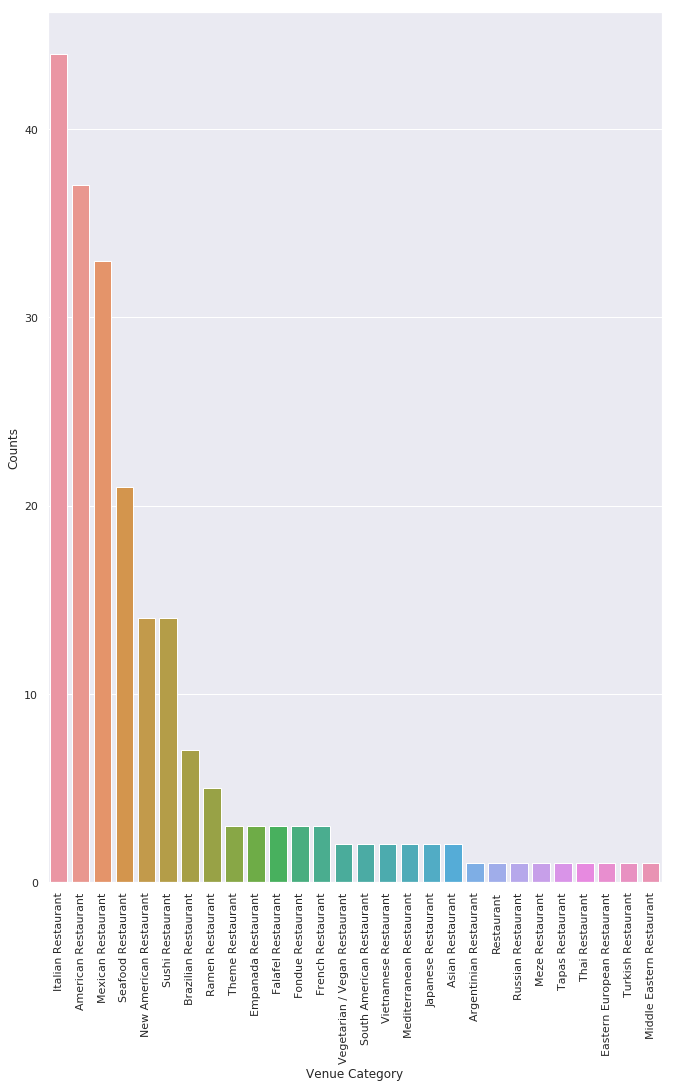

In [41]:
#Now lets plot bar chart
sns.set(rc={'figure.figsize':(11,16)})
plot = sns.barplot(x='Venue Category',y='Counts',data=res_count2)
plot.set_xticklabels(res_count2['Venue Category'],rotation=90)

In [65]:
res_count2.set_index('Venue Category', inplace=True)

Text(0, 0.5, 'Restaurant Count')

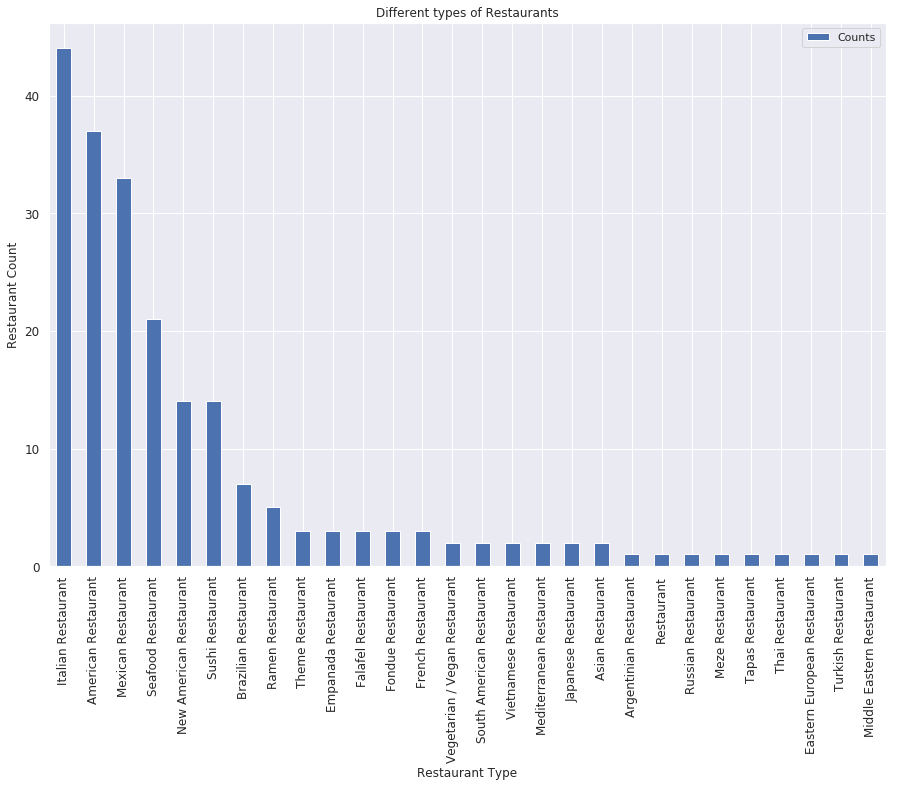

In [66]:
#Another type of bar chart
ax = res_count2.plot(kind='bar', title ="Different types of Restaurants",figsize=(15,10),legend=True, fontsize=12)
ax.set_xlabel("Restaurant Type",fontsize=12)
ax.set_ylabel("Restaurant Count",fontsize=12)

**Now lets analyze Each Neighborhood specifically for French Restaurants**

In [43]:
# check if the results contain "French Restaurants"
"French Restaurant" in sd_venues['Venue Category'].unique()

True

In [44]:
#lets get the details of French Restaurant in neighborhoods
sd_venues[sd_venues['Venue Category'] == 'French Restaurant']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
43,CIVIC_CORE,32.7159,-117.1595,Le Fontainbleau - The Westgate Hotel,32.716629,-117.162721,French Restaurant
132,COLUMBIA,32.7178,-117.1673,Le Fontainbleau - The Westgate Hotel,32.716629,-117.162721,French Restaurant
232,CORTEZ HILL,32.7214,-117.1598,Le Fontainbleau - The Westgate Hotel,32.716629,-117.162721,French Restaurant


So there are three French Restaurant in neighborhoods CIVIC_CORE, COLUMBIA and CORTEZ HILL

In [45]:
# one hot encoding
to_onehot = pd.get_dummies(sd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = sd_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

#lets check size of new frame
print(to_onehot.shape)
to_onehot.head()

(700, 130)


,Neighborhoods,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Baseball Stadium,Beer Bar,Beer Store,Boat or Ferry,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Business Service,Café,Candy Store,Cheese Shop,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Cruise,Cupcake Shop,Deli / Bodega,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fish Market,Fondue Restaurant,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Lingerie Store,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Outdoor Sculpture,Park,Piano Bar,Pier,Pilates Studio,Pizza Place,Plaza,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Plaza,Smoke Shop,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Tiki Bar,Tour Provider,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop
0,CIVIC_CORE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CIVIC_CORE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CIVIC_CORE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,CIVIC_CORE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CIVIC_CORE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [46]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped

(7, 130)


,Neighborhoods,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Baseball Stadium,Beer Bar,Beer Store,Boat or Ferry,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Business Service,Café,Candy Store,Cheese Shop,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Cruise,Cupcake Shop,Deli / Bodega,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fish Market,Fondue Restaurant,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Lingerie Store,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Outdoor Sculpture,Park,Piano Bar,Pier,Pilates Studio,Pizza Place,Plaza,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Plaza,Smoke Shop,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Tiki Bar,Tour Provider,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop
0,CIVIC_CORE,0.01,0.06,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.05,0.00,0.00,0.01,0.00,0.00,0.02,0.01,0.02,0.00,0.02,0.01,0.05,0.00,0.00,0.01,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.07,0.00,0.00,0.00,0.01,0.04,0.00,0.01,0.00,0.02,0.01,0.02,0.01,0.01,0.08,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.02,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.03,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.03,0.02,0.00,0.00,0.02,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.00
1,COLUMBIA,0.00,0.06,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.02,0.02,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.08,0.00,0.00,0.02,0.00,0.11,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.01,0.02,0.00,0.00,0.03,0.00,0.01,0.01,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.02,0.00,0.00,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.04,0.00
2,CORTEZ HILL,0.00,0.06,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.03,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.02,0.00,0.02,0.01,0.03,0.00,0.00,0.00,0.00,0.01,0.05,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.00,0.01,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.07,0.00,0.00,0.02,0.00,0.06,0.00,0.00,0.01,0.00,0.01,0.01,0.00,0.00,0.05,0.00,0.01,0.01,0.00,0.00,0.01,0.02,0.01,0.02,0.00,0.00,0.02,0.00,0.00,0.01,0.03,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.03,0.03,0.00,0.00,0.02,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.00
3,EAST VILLAGE,0.00,0.05,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.01,0.01,0.01,0.00,0.00,0.02,0.02,0.02,0.00,0.02,0.00,0.05,0.00,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.00,0.01,0.00,

In [47]:
#Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in to_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = to_grouped[to_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CIVIC_CORE----
                 venue  freq
0   Mexican Restaurant  0.08
1                Hotel  0.07
2  American Restaurant  0.06
3                 Café  0.05
4                  Bar  0.05


----COLUMBIA----
                 venue  freq
0   Italian Restaurant  0.11
1                Hotel  0.08
2  American Restaurant  0.06
3          Coffee Shop  0.05
4             Wine Bar  0.04


----CORTEZ HILL----
                 venue  freq
0                Hotel  0.07
1   Italian Restaurant  0.06
2  American Restaurant  0.06
3          Coffee Shop  0.05
4   Mexican Restaurant  0.05


----EAST VILLAGE----
                 venue  freq
0                Hotel  0.08
1   Mexican Restaurant  0.07
2  American Restaurant  0.05
3                 Café  0.05
4                  Bar  0.05


----GASLAMP----
                venue  freq
0               Hotel  0.12
1                 Bar  0.10
2                Café  0.06
3          Steakhouse  0.06
4  Mexican Restaurant  0.05


----LITTLE ITALY----
            

In [48]:
#let's write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = to_grouped['Neighborhoods']

for ind in np.arange(to_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(to_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CIVIC_CORE,Mexican Restaurant,Hotel,American Restaurant,Café,Bar,Italian Restaurant,Sushi Restaurant,Seafood Restaurant,Coffee Shop,Ramen Restaurant
1,COLUMBIA,Italian Restaurant,Hotel,American Restaurant,Coffee Shop,Wine Bar,Park,Mexican Restaurant,Museum,Steakhouse,Seafood Restaurant
2,CORTEZ HILL,Hotel,Italian Restaurant,American Restaurant,Coffee Shop,Mexican Restaurant,Seafood Restaurant,Sushi Restaurant,Bar,Café,Pizza Place
3,EAST VILLAGE,Hotel,Mexican Restaurant,American Restaurant,Café,Bar,Italian Restaurant,Lounge,Gastropub,Seafood Restaurant,Burger Joint
4,GASLAMP,Hotel,Bar,Café,Steakhouse,Mexican Restaurant,American Restaurant,Italian Restaurant,Lounge,Seafood Restaurant,Breakfast Spot
5,LITTLE ITALY,Italian Restaurant,Coffee Shop,American Restaurant,Hotel,Wine Bar,Pizza Place,Convenience Store,New American Restaurant,Brewery,Japanese Restaurant
6,MARINA,Hotel,Seafood Restaurant,Coffee Shop,American Restaurant,Mexican Restaurant,Park,New American Restaurant,Steakhouse,Gift Shop,Italian Restaurant


In [50]:
neighborhoods_venues_sorted.shape

(7, 11)

In [51]:
#check num of French Restaurant
len(to_grouped[to_grouped["French Restaurant"] > 0])

3

Create a new dataframe to find **French Restaurants** only

In [52]:
to_french = to_grouped[["Neighborhoods","French Restaurant"]]

In [53]:
to_french

,Neighborhoods,French Restaurant
0,CIVIC_CORE,0.01
1,COLUMBIA,0.01
2,CORTEZ HILL,0.01
3,EAST VILLAGE,0.00
4,GASLAMP,0.00
5,LITTLE ITALY,0.00
6,MARINA,0.00


## Find the clusters in Neighborhood using k-means clustering algorithm
**Lets find the proper value for k parameter to be used in k means clustering**

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_l

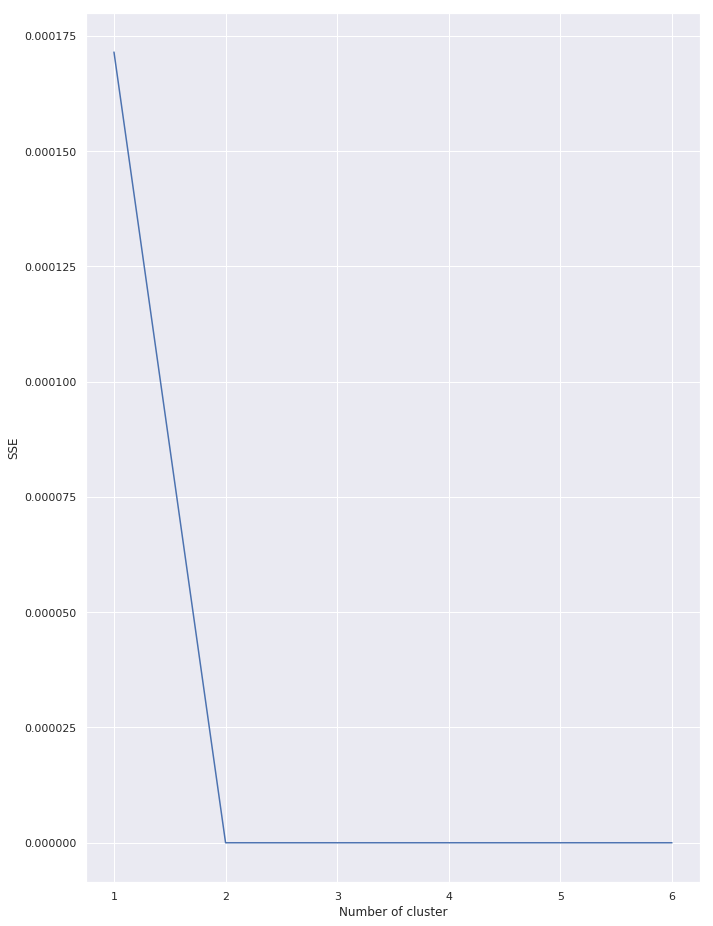

In [54]:
sse = {}
for k in range(1,7):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(to_french.drop(["Neighborhoods"], 1))
    to_french['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

As seen in above graph the k value to be used is 2

## Cluster Neighborhoods

Run k-means to cluster the neighborhoods in Downtown San Diego into 2 clusters(k = 2)

In [55]:
# set number of clusters
toclusters = 2

to_clustering = to_french.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=toclusters, random_state=0).fit(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 0, 0, 0, 0], dtype=int32)

In [56]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = to_french.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [57]:
to_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
to_merged

,Neighborhood,French Restaurant,Cluster,Cluster Labels
0,CIVIC_CORE,0.01,1,1
1,COLUMBIA,0.01,1,1
2,CORTEZ HILL,0.01,1,1
3,EAST VILLAGE,0.00,0,0
4,GASLAMP,0.00,0,0
5,LITTLE ITALY,0.00,0,0
6,MARINA,0.00,0,0


In [58]:
# add latitude/longitude for each neighborhood to merged frame
to_merged = to_merged.join(sd_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(700, 10)


,Neighborhood,French Restaurant,Cluster,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,House of Blues San Diego,32.716370,-117.159528,Music Venue
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,"THE US GRANT, A Luxury Collection Hotel, San D...",32.716149,-117.161527,Hotel
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,Vin de Syrah Wine Parlor,32.714723,-117.160040,Wine Bar
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,The Taco Stand Downtown,32.717749,-117.158497,Taco Place
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,Donut Bar,32.717619,-117.158757,Donut Shop


In [59]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.head()

(700, 10)


,Neighborhood,French Restaurant,Cluster,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,EAST VILLAGE,0.0,0,0,32.7137,-117.1536,Empanada Kitchen,32.716635,-117.157114,Empanada Restaurant
4,GASLAMP,0.0,0,0,32.7101,-117.1601,Blue Point Coastal Cuisine,32.711420,-117.160077,American Restaurant
4,GASLAMP,0.0,0,0,32.7101,-117.1601,Tabac Cafe & Hookah,32.711260,-117.162007,Café
4,GASLAMP,0.0,0,0,32.7101,-117.1601,Coffee And Art,32.713103,-117.159213,Café
4,GASLAMP,0.0,0,0,32.7101,-117.1601,Gaslamp Strip Club Restaurant,32.708922,-117.160183,Steakhouse


Now lets visualize the generated clusters

In [60]:
# create map
map_clusters = folium.Map(location=[lat_sd, lon_sd], zoom_start=11)

# set color scheme for the clusters
x = np.arange(toclusters)
ys = [i+x+(i*x)**2 for i in range(toclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As shown in map   
**Cluster 1** - contains the Downtown San Diego neighborhoods of **CIVIC_CORE, COLUMBIA and CORTEZ HILL** which have at least one French Restaurant     
**Cluster 0** - contains the Downtown San Diego neighborhoods of **MARINA, GASLAMP, LITTLE ITALY and EAST VILLAGE** which has no French Restaurant

In [106]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

In [61]:
#get the neighborhood names per cluster
to_merged.groupby('Cluster Labels')['Neighborhood'].unique()

Cluster Labels
0    [EAST VILLAGE, GASLAMP, LITTLE ITALY, MARINA]
1              [CIVIC_CORE, COLUMBIA, CORTEZ HILL]
Name: Neighborhood, dtype: object

In [62]:
#lets check the French Restaurant details with cluster info
to_merged[to_merged['Venue Category'] == 'French Restaurant']

,Neighborhood,French Restaurant,Cluster,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,COLUMBIA,0.01,1,1,32.7178,-117.1673,Le Fontainbleau - The Westgate Hotel,32.716629,-117.162721,French Restaurant
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,Le Fontainbleau - The Westgate Hotel,32.716629,-117.162721,French Restaurant
2,CORTEZ HILL,0.01,1,1,32.7214,-117.1598,Le Fontainbleau - The Westgate Hotel,32.716629,-117.162721,French Restaurant


## Lets examine the Clusters

In [63]:
#Cluster 1 - contains the Downtown San Diego neighborhoods with at least one French Restaurant in it
to_merged.loc[to_merged['Cluster Labels'] == 1].head()

,Neighborhood,French Restaurant,Cluster,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,Mina Lounge,32.712014,-117.159306,Lounge
1,COLUMBIA,0.01,1,1,32.7178,-117.1673,Music Box,32.719423,-117.168214,Music Venue
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,Rustic Root,32.711005,-117.159999,American Restaurant
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,Half Door Brewing Company,32.710380,-117.156385,Brewery
0,CIVIC_CORE,0.01,1,1,32.7159,-117.1595,Lola 55,32.713853,-117.153028,Taco Place


In [64]:
#Cluster 0 - contains the Downtown San Diego neighborhoods with no French Restaurant in it
to_merged.loc[to_merged['Cluster Labels'] == 0].head()

,Neighborhood,French Restaurant,Cluster,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,EAST VILLAGE,0.0,0,0,32.7137,-117.1536,Empanada Kitchen,32.716635,-117.157114,Empanada Restaurant
4,GASLAMP,0.0,0,0,32.7101,-117.1601,Blue Point Coastal Cuisine,32.711420,-117.160077,American Restaurant
4,GASLAMP,0.0,0,0,32.7101,-117.1601,Tabac Cafe & Hookah,32.711260,-117.162007,Café
4,GASLAMP,0.0,0,0,32.7101,-117.1601,Coffee And Art,32.713103,-117.159213,Café
4,GASLAMP,0.0,0,0,32.7101,-117.1601,Gaslamp Strip Club Restaurant,32.708922,-117.160183,Steakhouse


## Observations/Conclusion

As we saw in the EDA and also results of ML clustering algorithm shows that there are two distinct clusters i.e.   
**Cluster 1** - contains the Downtown San Diego neighborhoods of **CIVIC_CORE, COLUMBIA and CORTEZ HILL** which have at least one French Restaurant          
**Cluster 0** - contains the Downtown San Diego neighborhoods of **MARINA, GASLAMP, LITTLE ITALY and EAST VILLAGE** which has no French Restaurant    
Hence we recommend our client **XYZ French food chain** to consider opening a new French Restaurant in any of the Neighborhoods of Cluster 0 i.e. **MARINA, GASLAMP, LITTLE ITALY or EAST VILLAGE**. The final call rest with our client based on other business considerations and their senior management decision.

## Thank you for the review...